In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import numpy as np
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
IMG_SIZE = 224

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.1, contrast=0.1, p=0.3),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda


In [ ]:
import os
import cv2
from torch.utils.data import Dataset, DataLoader

class StrokeDataset(Dataset):
    def __init__(self, root_dir, transform=None, mode='classification'):
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode

        if self.mode == 'classification':
            self.normal_images = [os.path.join(root_dir, 'normal', img)
                                  for img in os.listdir(os.path.join(root_dir, 'normal'))
                                  if img.endswith('.png')]
            self.stroke_images = [os.path.join(root_dir, 'stroke', 'png', img)
                                  for img in os.listdir(os.path.join(root_dir, 'stroke', 'png'))
                                  if img.endswith('.png')]
            self.image_paths = self.normal_images + self.stroke_images
            self.labels = [0] * len(self.normal_images) + [1] * len(self.stroke_images)

        elif self.mode == 'segmentation':
            png_dir = os.path.join(root_dir, 'stroke', 'png')
            mask_dir = os.path.join(root_dir, 'stroke', 'mask')
            self.image_paths = sorted([os.path.join(png_dir, f) for f in os.listdir(png_dir)])
            self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if self.mode == 'classification':
            img = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
            if self.transform:
                img = self.transform(image=img)['image']
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return img, label

        elif self.mode == 'segmentation':
            img = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
            if self.transform:
                augmented = self.transform(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']
            mask = (mask > 0.5).float()
            return img, mask.unsqueeze(0) # Add channel dimension for consistency with image

In [ ]:
# Paths
DATA_DIR = "/content/drive/MyDrive/preprocessed_dataset"
train_dir = f"{DATA_DIR}/train"
val_dir = f"{DATA_DIR}/val"

# Use your same dataset class and augmentations
train_dataset_cls = StrokeDataset(root_dir=train_dir, transform=train_transform, mode='classification')
val_dataset_cls = StrokeDataset(root_dir=val_dir, transform=val_test_transform, mode='classification')

# Dataloaders
train_loader_cls = DataLoader(train_dataset_cls, batch_size=16, shuffle=True)
val_loader_cls = DataLoader(val_dataset_cls, batch_size=16, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class ViT_CNN_Hybrid(nn.Module):
    def __init__(self, num_classes=2):
        super(ViT_CNN_Hybrid, self).__init__()

        # --- CNN Backbone ---
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56
        )

        # --- Vision Transformer Backbone ---
        self.vit = models.vit_b_16(weights=None)
        self.vit.heads = nn.Identity()  # remove original head
        self.vit.conv_proj = nn.Conv2d(1, 768, kernel_size=16, stride=16)

        # --- Compute CNN feature size dynamically ---
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 224, 224)
            cnn_out = self.cnn(dummy)
            cnn_feat_dim = cnn_out.view(1, -1).shape[1]  # 64*56*56 = 200,704

        fusion_dim = 768 + cnn_feat_dim

        # --- Fusion Layers ---
        self.fc = nn.Sequential(
            nn.Linear(fusion_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        cnn_feat = self.cnn(x)
        vit_feat = self.vit(x)

        cnn_feat = torch.flatten(cnn_feat, 1)
        combined = torch.cat((vit_feat, cnn_feat), dim=1)
        out = self.fc(combined)
        return out

# Instantiate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT_CNN_Hybrid(num_classes=2).to(device)
print("✅ Model successfully built and moved to", device)


✅ Model successfully built and moved to cuda


In [ ]:
# ============================================
# 3️⃣ TRAINING SETUP
# ============================================

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
EPOCHS = 20


In [ ]:
# ============================================
# 4️⃣ TRAINING LOOP
# ============================================
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, labels in train_loader_cls:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_losses.append(total_loss / len(train_loader_cls))
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader_cls:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_losses.append(val_loss / len(val_loader_cls))
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}]  "
          f"Train Loss: {train_losses[-1]:.4f}  Val Loss: {val_losses[-1]:.4f}  "
          f"Train Acc: {train_acc:.4f}  Val Acc: {val_acc:.4f}")


Epoch [1/20]  Train Loss: 0.9036  Val Loss: 0.2201  Train Acc: 0.8359  Val Acc: 0.9247
Epoch [2/20]  Train Loss: 0.2378  Val Loss: 0.2223  Train Acc: 0.9082  Val Acc: 0.8889
Epoch [3/20]  Train Loss: 0.2047  Val Loss: 0.1458  Train Acc: 0.9184  Val Acc: 0.9032
Epoch [4/20]  Train Loss: 0.1511  Val Loss: 0.1590  Train Acc: 0.9390  Val Acc: 0.9104
Epoch [5/20]  Train Loss: 0.1257  Val Loss: 0.2406  Train Acc: 0.9479  Val Acc: 0.8996
Epoch [6/20]  Train Loss: 0.1223  Val Loss: 0.2544  Train Acc: 0.9527  Val Acc: 0.8996
Epoch [7/20]  Train Loss: 0.1249  Val Loss: 0.2006  Train Acc: 0.9543  Val Acc: 0.9068
Epoch [8/20]  Train Loss: 0.1047  Val Loss: 0.2352  Train Acc: 0.9636  Val Acc: 0.9068
Epoch [9/20]  Train Loss: 0.1071  Val Loss: 0.1946  Train Acc: 0.9640  Val Acc: 0.9211
Epoch [10/20]  Train Loss: 0.0850  Val Loss: 0.2605  Train Acc: 0.9652  Val Acc: 0.8996
Epoch [11/20]  Train Loss: 0.0859  Val Loss: 0.2445  Train Acc: 0.9721  Val Acc: 0.9032
Epoch [12/20]  Train Loss: 0.0805  Val Lo

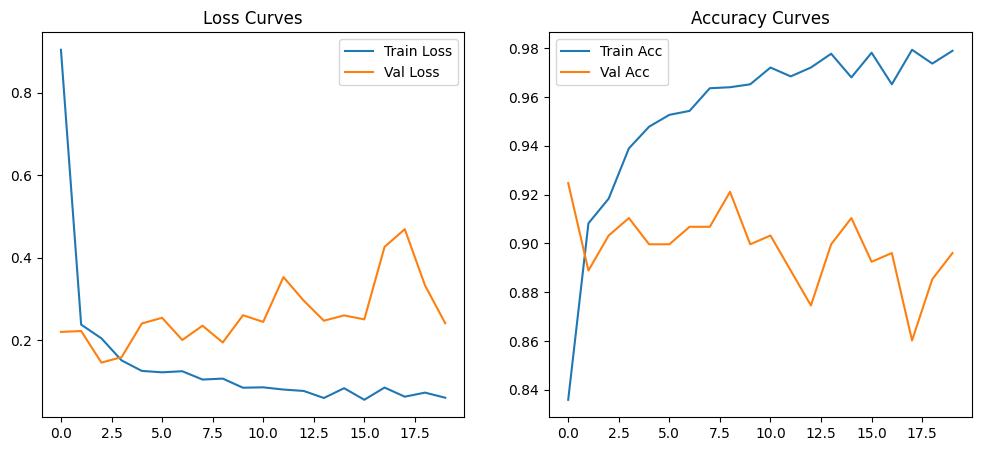

In [ ]:
# ============================================
# 5️⃣ PLOT TRAINING CURVES
# ============================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.title("Loss Curves")

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend(); plt.title("Accuracy Curves")
plt.show()



Classification Report:

              precision    recall  f1-score   support

      Normal       0.85      0.92      0.89       270
      Stroke       0.94      0.88      0.91       352

    accuracy                           0.90       622
   macro avg       0.89      0.90      0.90       622
weighted avg       0.90      0.90      0.90       622



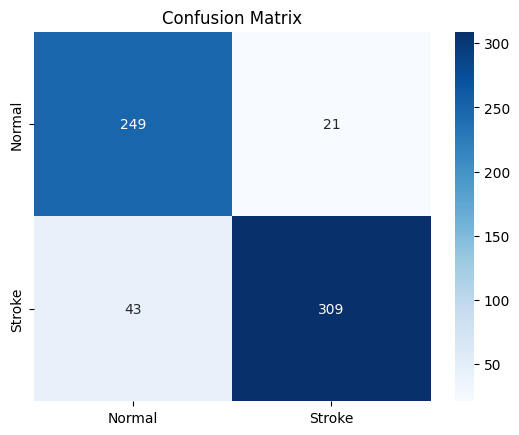

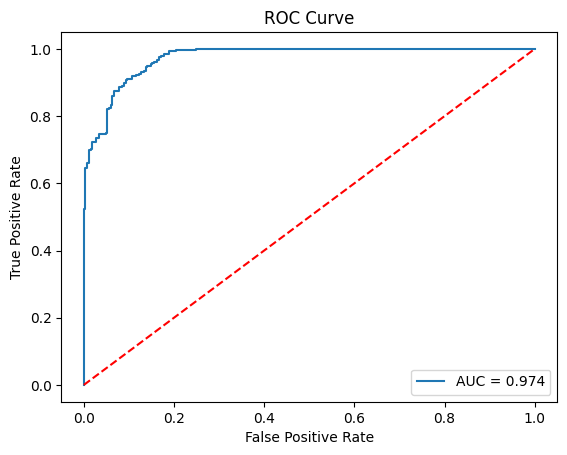

In [ ]:
# ============================================
# 6️⃣ EVALUATION ON TEST DATA
# ============================================

test_dir = f"{DATA_DIR}/test"

# Use your same dataset class and augmentations
test_dataset_cls = StrokeDataset(root_dir=test_dir, transform=val_test_transform, mode='classification')

# Dataloaders
test_loader_cls  = DataLoader(test_dataset_cls, batch_size=16, shuffle=False)

model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader_cls:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Classification report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=["Normal", "Stroke"]))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Normal", "Stroke"],
            yticklabels=["Normal", "Stroke"])
plt.title("Confusion Matrix")
plt.show()

# ROC & AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "r--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend(); plt.show()


In [ ]:
# ============================================
# 7️⃣ SAVE MODEL FOR WEB DEPLOYMENT
# ============================================
save_path = "/content/drive/MyDrive/stroke_models/vit_cnn_classifier.pth"

os.makedirs("/content/drive/MyDrive/stroke_models", exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"✅ Model saved to: {save_path}")


✅ Model saved to: /content/drive/MyDrive/stroke_models/vit_cnn_classifier.pth


In [ ]:
# ==================================================
# STEP 1: Import required libraries
# ==================================================
import torch
from torchvision import transforms
from PIL import Image
import torch.nn as nn

In [ ]:
class ViT_CNN_Hybrid(nn.Module):
    def __init__(self, num_classes=2):
        super(ViT_CNN_Hybrid, self).__init__()

        # --- CNN Backbone ---
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56
        )

        # --- Vision Transformer Backbone ---
        self.vit = models.vit_b_16(weights=None)
        self.vit.heads = nn.Identity()  # remove original head
        self.vit.conv_proj = nn.Conv2d(1, 768, kernel_size=16, stride=16)

        # --- Compute CNN feature size dynamically ---
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 224, 224)
            cnn_out = self.cnn(dummy)
            cnn_feat_dim = cnn_out.view(1, -1).shape[1]  # 64*56*56 = 200,704

        fusion_dim = 768 + cnn_feat_dim

        # --- Fusion Layers ---
        self.fc = nn.Sequential(
            nn.Linear(fusion_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        cnn_feat = self.cnn(x)
        vit_feat = self.vit(x)

        cnn_feat = torch.flatten(cnn_feat, 1)
        combined = torch.cat((vit_feat, cnn_feat), dim=1)
        out = self.fc(combined)
        return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/drive/MyDrive/stroke_models/vit_cnn_classifier.pth"   # <-- your saved model file

model = ViT_CNN_Hybrid().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

print("✅ Model loaded successfully from Drive!")

✅ Model loaded successfully from Drive!


In [ ]:
# ==================================================
# STEP 5: Define transform (must match your training)
# ==================================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


In [ ]:
# ==================================================
# STEP 6: Function to test a single CT image
# ==================================================
def test_single_image(image_path):
    # Convert to grayscale (since CNN input channel=1)
    img = Image.open(image_path).convert("L")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)
        pred = torch.argmax(probs, dim=1).item()

    classes = ["Normal", "Stroke"]
    print(f"\n🩻 Prediction: {classes[pred]} (Confidence: {probs[0][pred]:.4f})")
    return classes[pred], probs[0][pred].item()

In [ ]:
test_single_image("/content/drive/MyDrive/test_ct9.png")


🩻 Prediction: Stroke (Confidence: 0.9546)


('Stroke', 0.9546154737472534)